In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import sys
sys.path.append("../..")
from data import utils
from src.utility import create_utility_func
from src.configuration import load_config
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 13})

In [2]:
def update_cluster_name(cluster_name):
    pos = cluster_name.rfind("cluster")
    if pos > 0:
        idx = int(cluster_name[pos+len("cluster"):])
        assert idx > 0
        cluster_name = cluster_name[:pos] + f"cluster{idx-1}"
    return cluster_name

def update_df_cluster_name(target_df):
    if "serve-cluster10" in target_df.cluster_name.unique():
        target_df.cluster_name = target_df.cluster_name.apply(update_cluster_name)
    return target_df


def postprocess(target_df):
    target_df = update_df_cluster_name(target_df)
    target_df.loc[~target_df.succeeded, "latency_ms"]  = np.nan
    return target_df

def calculate_utility(df, unit_time, quantile, util_fn=None, slo_target_ms=None):
    utility_dict = {}
    df["bin"] = df.arrival_ts // unit_time
    for cluster_name in df.cluster_name.unique():
        latency_quantile = df[df.cluster_name == cluster_name][["latency_ms", "bin"]].fillna(np.nan_to_num(np.inf)).groupby(by="bin").quantile(quantile)
        if util_fn is not None:
            utility = latency_quantile["latency_ms"].apply(util_fn)
        else:
            utility = (slo_target_ms / latency_quantile.latency_ms).clip(upper=1.0)#.fillna(0)
        utility_dict[cluster_name] = utility
    return pd.DataFrame(utility_dict)

def calculate_slo_violations(df, unit_time, slo_target_ms):
    slo_dict = {}
    df["slo"] = ((df.latency_ms <= slo_target_ms) & df.succeeded)
    df["bin"] = df.arrival_ts // unit_time
    for cluster_name in df.cluster_name.unique():
        slo_bins = df[df.cluster_name == cluster_name][["slo", "bin"]]
        def calc_slo_rate(x):
            return x.sum()/len(x)
        slo_rate_per_bin = slo_bins.groupby(by="bin")["slo"].apply(calc_slo_rate)
        slo_dict[cluster_name] = slo_rate_per_bin
    return pd.DataFrame(slo_dict)

In [3]:
quantile = 0.99
slo_target_ms = 720
unit_time = 60

def preprocess_data(num_cpus):
    processed_dataset_path = Path(f"timeline_data_{num_cpus}.pkl.gz")
    if processed_dataset_path.exists():
        print("Loading preprocessed data:", processed_dataset_path)
        return pd.read_pickle(processed_dataset_path)

    print("Preprocessed data does not exist:", processed_dataset_path)

    aiad_path = Path(f"../../results/faro/resnet34/top9_twitter_1_1600_avgproc_min_int5m_reduced_6hr_augmented/{num_cpus}_cpus/aiad")
    oneshot_path = Path(f"../../results/faro/resnet34/top9_twitter_1_1600_avgproc_min_int5m_reduced_6hr_augmented/{num_cpus}_cpus/oneshot")
    mark_path = Path(f"../../results/faro/resnet34/top9_twitter_1_1600_avgproc_min_int5m_reduced_6hr_augmented/{num_cpus}_cpus/mark")
    faro_path = Path(f"../../results/faro/resnet34/top9_twitter_1_1600_avgproc_min_int5m_reduced_6hr_augmented/{num_cpus}_cpus/faro_fair_sum")
    faro_sum_path = Path(f"../../results/faro/resnet34/top9_twitter_1_1600_avgproc_min_int5m_reduced_6hr_augmented/{num_cpus}_cpus/faro_sum")
    fairshare_path = Path(f"../../results/faro/resnet34/top9_twitter_1_1600_avgproc_min_int5m_reduced_6hr_augmented/{num_cpus}_cpus/fairshare")

    aiad_df = postprocess(pd.read_pickle(aiad_path / "metrics.pkl.gz"))
    oneshot_df = postprocess(pd.read_pickle(oneshot_path / "metrics.pkl.gz"))
    mark_df = postprocess(pd.read_pickle(mark_path / "metrics.pkl.gz"))
    faro_df = postprocess(pd.read_pickle(faro_path / "metrics.pkl.gz"))
    fairshare_df = postprocess(pd.read_pickle(fairshare_path / "metrics.pkl.gz"))
    faro_sum_df = pd.read_pickle(faro_sum_path / "metrics.pkl.gz")

    # util_fn = None
    util_fn = create_utility_func("latency", slo_target_ms)

    aiad_utility_df = calculate_utility(aiad_df, unit_time, quantile, util_fn=util_fn, slo_target_ms=slo_target_ms)
    oneshot_utility_df = calculate_utility(oneshot_df, unit_time, quantile, util_fn=util_fn, slo_target_ms=slo_target_ms)
    mark_utility_df = calculate_utility(mark_df, unit_time, quantile, util_fn=util_fn, slo_target_ms=slo_target_ms)
    faro_utility_df = calculate_utility(faro_df, unit_time, quantile, util_fn=util_fn, slo_target_ms=slo_target_ms)
    fairshare_utility_df = calculate_utility(fairshare_df, unit_time, quantile, util_fn=util_fn, slo_target_ms=slo_target_ms)
    faro_sum_utility_df = calculate_utility(faro_sum_df, unit_time, quantile, util_fn=util_fn, slo_target_ms=slo_target_ms)

    counts = (faro_df.arrival_ts / 60).astype(int).value_counts().sort_index()[:359]

    per_cluster_counts = {}
    for target_cluster in faro_df.cluster_name.unique():
        per_cluster_counts[target_cluster] = (faro_df[faro_df.cluster_name == target_cluster].arrival_ts / 60).astype(int).value_counts().sort_index()[:359]

    oneshot_slo_rate_df = calculate_slo_violations(oneshot_df, unit_time, slo_target_ms)
    aiad_slo_rate_df = calculate_slo_violations(aiad_df, unit_time, slo_target_ms)
    mark_slo_rate_df = calculate_slo_violations(mark_df, unit_time, slo_target_ms)
    faro_slo_rate_df = calculate_slo_violations(faro_df, unit_time, slo_target_ms)
    fairshare_slo_rate_df = calculate_slo_violations(fairshare_df, unit_time, slo_target_ms)
    faro_sum_slo_rate_df = calculate_slo_violations(faro_sum_df, unit_time, slo_target_ms)

    # save parsed data to include repository. The original data is too large to include in the repository
    processed_dataset = {
        "counts": counts,
        "per_cluster_counts": per_cluster_counts,
        "aiad_utility_df": aiad_utility_df,
        "oneshot_utility_df": oneshot_utility_df,
        "mark_utility_df": mark_utility_df,
        "faro_utility_df": faro_utility_df,
        "fairshare_utility_df": fairshare_utility_df,
        "faro_sum_utility_df": faro_sum_utility_df,
        "oneshot_slo_rate_df" : oneshot_slo_rate_df,
        "aiad_slo_rate_df" : aiad_slo_rate_df,
        "mark_slo_rate_df" : mark_slo_rate_df,
        "faro_slo_rate_df" : faro_slo_rate_df,
        "fairshare_slo_rate_df" : fairshare_slo_rate_df,
        'faro_sum_slo_rate_df': faro_sum_slo_rate_df,
    }
    print(f"Writing processed data to {processed_dataset_path}...")
    pd.to_pickle(processed_dataset, processed_dataset_path)
    return processed_dataset

In [4]:
num_cpus = 32
processed_dataset = preprocess_data(num_cpus)

counts = processed_dataset["counts"]
per_cluster_counts = processed_dataset["per_cluster_counts"]
aiad_utility_df = processed_dataset["aiad_utility_df"]
oneshot_utility_df = processed_dataset["oneshot_utility_df"]
mark_utility_df = processed_dataset["mark_utility_df"]
faro_utility_df = processed_dataset["faro_utility_df"]
fairshare_utility_df = processed_dataset["fairshare_utility_df"]
faro_sum_utility_df = processed_dataset["faro_sum_utility_df"]
oneshot_slo_rate_df = processed_dataset["oneshot_slo_rate_df"]
aiad_slo_rate_df = processed_dataset["aiad_slo_rate_df"]
mark_slo_rate_df = processed_dataset["mark_slo_rate_df"]
faro_slo_rate_df = processed_dataset["faro_slo_rate_df"]
fairshare_slo_rate_df = processed_dataset["fairshare_slo_rate_df"]
faro_sum_slo_rate_df = processed_dataset["faro_sum_slo_rate_df"]

normalized_counts = counts / counts.max()

Loading preprocessed data: timeline_data_32.pkl.gz


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


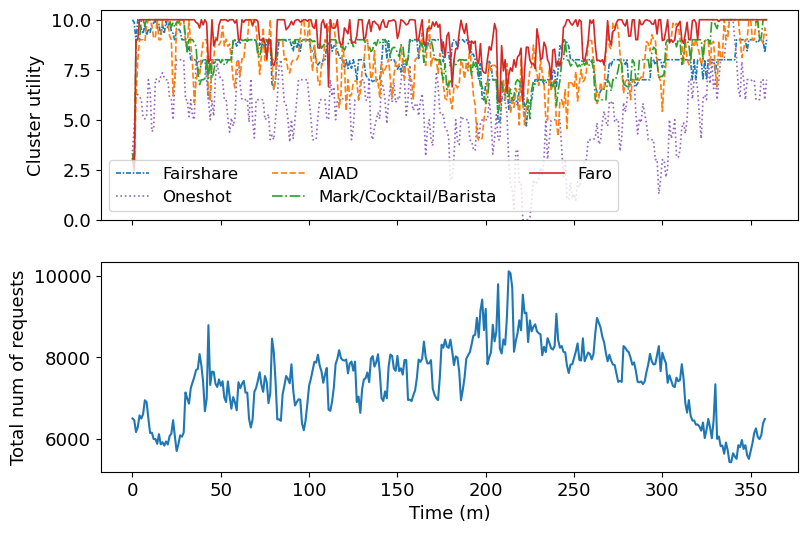

In [5]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 6))
linewidth = 1.2

# plt.rcParams.update({'font.size': 14})
# fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12, 8))
# linewidth = None

ax[0].plot(fairshare_utility_df.sum(axis=1).values[:360], label="Fairshare", linestyle=(0, (3, 1, 1, 1)), color="tab:blue", linewidth=linewidth)
ax[0].plot(oneshot_utility_df.sum(axis=1).values[:360], label="Oneshot", linestyle=":", color="tab:purple", linewidth=linewidth)
ax[0].plot(aiad_utility_df.sum(axis=1).values[:360], label="AIAD", linestyle="--", color="tab:orange", linewidth=linewidth)
ax[0].plot(mark_utility_df.sum(axis=1).values[:360], label="Mark/Cocktail/Barista", linestyle="-.", color="tab:green", linewidth=linewidth)
ax[0].plot(faro_utility_df.sum(axis=1).values[:360], label="Faro", color="tab:red", linewidth=linewidth)
ax[0].legend(ncol=3, fontsize=12, loc="lower left")
ax[0].set_ylabel("Cluster utility")
ax[0].set_ylim(bottom=0)

# plt.fill_between(normalized_counts.index, normalized_counts.values, label="counts", color="grey", alpha=0.7)
counts.plot(ax=ax[1]) # label="Request counts", 
# ax[1].set_ylabel("Total number of requests")
ax[1].set_ylabel("Total num of requests")
plt.xlabel("Time (m)")

fig.savefig(f"images/{num_cpus}_utility_timeline.eps", bbox_inches="tight")
# plt.rcParams.update({'font.size': 13})
# plt.legend()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


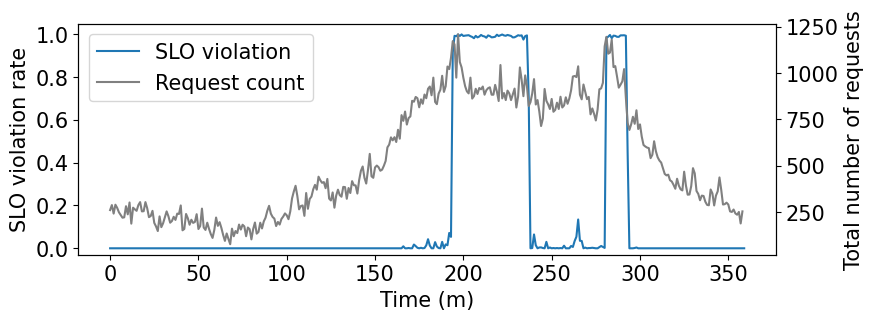

In [6]:
# for i in range(10):
for i in [2]:
    target_cluster = f"serve-cluster{i}"

    plt.rcParams.update({'font.size': 15})
    fig, ax = plt.subplots(1, 1, figsize=(9, 3))
    ax = [ax, ax.twinx()]

    ax[0].plot((1 - fairshare_slo_rate_df[target_cluster].values[:360]), label="SLO violation")
    ax[0].set_ylabel("SLO violation rate")
    ax[0].set_ylim(bottom=0)

    # plt.fill_between(normalized_counts.index, normalized_counts.values, label="counts", color="grey", alpha=0.7)
    # (faro_df[faro_df.cluster_name == target_cluster].arrival_ts / 60).astype(int).value_counts().sort_index()[:359].plot(ax=ax[1], label="Request count", color="gray")
    per_cluster_counts[target_cluster].plot(ax=ax[1], label="Request count", color="gray")
    ax[1].set_ylabel("Total number of requests")
    # plt.xlabel("Time (m)")
    ax[0].set_xlabel("Time (m)")
    ax[0].set_ylim(bottom=-0.03)

    lines = []
    lines.extend(ax[0].lines)
    lines.extend(ax[1].lines)
    plt.legend(lines, [l.get_label() for l in lines])

    fig.savefig(f"images/{num_cpus}_fairshare_slo_timeline_{target_cluster}.eps", bbox_inches="tight")
    plt.rcParams.update({'font.size': 13})
    # plt.close(fig)
# plt.legend()

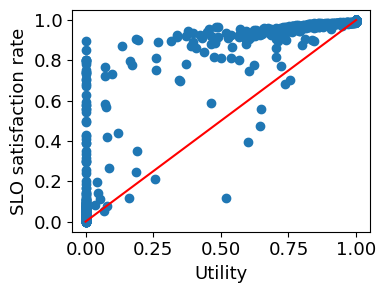

In [7]:
utility_list = []
slo_rate_list = []

utilities = []
slo_rates = []

for cluster_name in faro_utility_df.columns:
    utility_per_bin = faro_utility_df[cluster_name]
    slo_rate_per_bin = faro_slo_rate_df[cluster_name]
    utilities.append(utility_per_bin.values[:359])
    slo_rates.append(slo_rate_per_bin.values[:359])
    # plt.scatter(x=utility_per_bin.values, y=slo_rate_per_bin.values, label=cluster_name)

factor = 0.6
plt.figure(figsize=(6.4 * factor, 4.8 * factor))
plt.scatter(np.concatenate(utilities), np.concatenate(slo_rates))
x = np.linspace(0, 1, 10)
# ax.plot(x, a * x + b, color="k")
plt.plot(x, x, color="r")
plt.xlabel("Utility")
plt.ylabel("SLO satisfaction rate")
plt.savefig("images/correlation.eps", bbox_inches="tight")
# plt.legend()
plt.rcParams.update({'font.size': 13})

In [8]:
cluster_name = 'serve-cluster1'
utility_per_bin = aiad_utility_df[cluster_name]
slo_rate_per_bin = aiad_slo_rate_df[cluster_name]
for i, (utility, slo_rate) in enumerate(zip(utility_per_bin.values, slo_rate_per_bin.values)):
    if utility > 0.2 and utility < 0.5 and slo_rate > 0.2 and slo_rate < 0.5:
        print(i, utility, slo_rate)

71 0.40153699438405904 0.33835341365461846


Text(0, 0.5, 'Avg SLO violation rate')

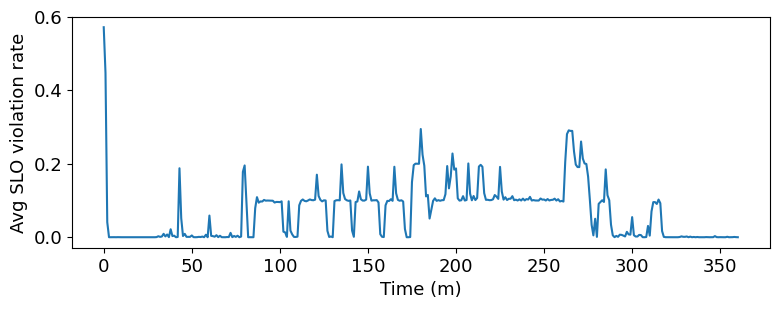

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(9, 3))
(1 - faro_sum_slo_rate_df.mean(axis=1)).plot(ax=ax)
ax.set_xlabel("Time (m)")
ax.set_ylabel("Avg SLO violation rate")

In [10]:
cilantro_log_path = Path("../../results/cilantro/workdirs_eks/utilwelflearn_exp_env_2_64_eks_1017235443")

def cilantro_calc_slo_rate(x):
    aggr = x.sum()
    return aggr["num_successes"]/aggr["num_events"]

slo_dict = {}
for log_file in cilantro_log_path.glob("*.csv"):
    # print(log_file.name)
    df = pd.read_csv(log_file)
    start_time = df["event_start_time"].min()
    df["start_ts"] = df["event_start_time"] - start_time
    # df["end_ts"] = df["event_end_time"] - start_time
    df["bin"] = df["start_ts"] // unit_time
    slo_dict[log_file.name] = df.groupby(by="bin")[["num_events", "num_successes"]].apply(cilantro_calc_slo_rate)

cilantro_slo_df = pd.DataFrame(slo_dict)

In [11]:
faro_sum_violation = 1 - faro_sum_slo_rate_df.mean(axis=1).mean()
cilantro_violation = 1 - cilantro_slo_df.mean(axis=1).mean()
print(faro_sum_violation, cilantro_violation)
print(cilantro_violation / faro_sum_violation)

print(1 - faro_sum_slo_rate_df.mean(axis=1)[10:].min())
print(1 - faro_sum_slo_rate_df.mean(axis=1).max())

0.06913037984687687 0.833461809644904
12.056375380708365
0.29454612641263767
0.0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


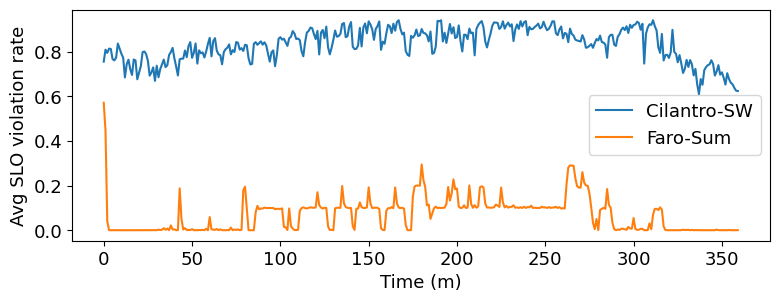

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(9, 3))
(1 - cilantro_slo_df.mean(axis=1))[:359].plot(ax=ax, label="Cilantro-SW")
(1 - faro_sum_slo_rate_df.mean(axis=1))[:359].plot(ax=ax, label="Faro-Sum")
ax.set_xlabel("Time (m)")
ax.set_ylabel("Avg SLO violation rate")
ax.legend()
fig.savefig(f"images/{num_cpus}_slo_timeline_with_cilantro.eps", bbox_inches="tight")